<a href="https://colab.research.google.com/github/MarkAvilin1/DS-and-ML/blob/main/Regression_HH_Salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Проект для прогноза уровень заработной платы на базе резюме из hh.ru, с помощью метода Регрессий

In [1]:
import numpy as np
import pandas as pd 

from tensorflow.keras.models import Sequential, Model  
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop 
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback 

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
#from google.colab import files

import random 
import math 
#import os 
import re
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import clear_output
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
fixed_df = pd.read_csv('/content/drive/MyDrive/My Projects/Datasetes/hh_fixed.csv')

In [4]:
fixed_df = fixed_df.drop(fixed_df.columns[0], axis=1)

In [5]:
for j in range(fixed_df.shape[1]):  
    for i in range(fixed_df.shape[0]): 
        if type(fixed_df.values[i][j])!= float: 
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0", "")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n", " ")
      
fixed_df.shape

(62967, 12)

In [6]:
lst = []
for i in range(35000):
  lst.append(fixed_df.values[i])

df = np.array(lst)
print(df.shape)
print(df[0])

(35000, 12)
['Мужчина ,  29 лет , родился 16 мая 1989' '40000 руб.'
 'Специалист по поддержке чата(support team) домашний агент'
 'Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая комм

In [7]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  if "М" in arg:
    out[0] = 1
  year_tec = 2020
  if (len(arg) > 7):
    out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  return list(utils.to_categorical(outClass, 11).astype('int'))


# Зарплата
def getParameterSalary(arg):
    num = arg
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()
        
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5
       
    return int(num)


# Данные о городе
def getParameterCity(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 1, 0]
  return [0, 0, 0, 1]

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0]
  if ("стажировка" in arg):           out[0]=1
  if ("частичная занятость" in arg):  out[1]=1
  if ("проектная работа" in arg):     out[2]=1
  if ("полная занятость" in arg):     out[3]=1
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ("гибкий график" in arg):    out[0]=1
  if ("полный день" in arg):      out[1]=1
  if ("сменный график" in arg):   out[2]=1
  if ("удаленная работа" in arg): out[3]=1
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] 
  if arg in "Высшее Higher education":  out[0] = 1
  if arg in "Среднее специальное":      out[1] = 1
  if arg in "Неоконченное высшее":      out[2] = 1
  if arg in "Среднее образование":      out[3] = 1
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1

  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
            years = int(yearsStr)
      
         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]]
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)
      
  return 12*years+months

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): 
    outClass = 1
  if (out > 12): 
    outClass = 2
  if (out > 24):
    outClass = 3
  if (out > 36): 
    outClass = 4
  if (out > 60): 
    outClass = 5
  if (out > 96):
    outClass = 6
  if (out > 120): 
    outClass = 7
  if (out > 156): 
    outClass = 8
  if (out > 192): 
    outClass = 9 
  if (out > 240): 
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]  
  age =getParameterAgeVect(result[1]) 
  city = getParameterCity(val[3])
  employment = getParameterEmployment(val[4]) 
  shedule = getParameterSchedule(val[5]) 
  education = getParameterEducation(val[9]) 
  experience = getParameterExperienceVector(val[6]) 
  out = [] 
  
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience
  
  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    x = getAllParameters(val)
    xTrain.append(x)
    yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  
  return (xTrain, yTrain)

In [8]:
(xTrain01, yTrain) = get01Data(df)

In [9]:
print(xTrain01.shape) 
print(yTrain.shape)
print(xTrain01[110])

(35000, 39)
(35000,)
[1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0]


In [10]:
def getXTrainTRez(values):
  xTrainTRez = []
  
  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]
    
    xTrainTRez.append(currText)
  
  xTrainTRez = np.array(xTrainTRez)
  
  return xTrainTRez

In [11]:
xTrainTRez = getXTrainTRez(df)

In [12]:
maxWordsCount = 5000 

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainTRez)        
xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez)

In [13]:
xTrainRez01 = tokenizer.sequences_to_matrix(xTrainRezIndexes)

In [14]:
print(xTrainRez01.shape)                             
print(xTrainRez01[0][0:100])

(35000, 5000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [20]:
input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(100, activation = "relu")(x1)

x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dropout(0.5)(x2)
x2 = Dense(100, activation="tanh")(input2)
x2 = Dropout(0.5)(x2)
x2 = Dense(20, activation = "elu")(x2)
x2 = Dense(5, activation = "elu")(x2)

x = concatenate([x1, x2]) # Объединяем все три ветки

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) # Финальный нейрон, делает регрессию

model = Model((input1, input2), x) # В Model загружаем стартовые и последнюю точки 

model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

In [21]:
history = model.fit([xTrain01[:30000], xTrainRez01[:30000]], 
                    yTrain[:30000], 
                    epochs= 100, 
                    validation_data=([xTrain01[33000:], xTrainRez01[33000:]], 
                    yTrain[33000:]), 
                    verbose=1)

Epoch 1/100
938/938 [==============================] - 5s 5ms/step - loss: 5682.6318 - mae: 35.8774 - val_loss: 1617.2571 - val_mae: 25.7320
Epoch 2/100
938/938 [==============================] - 4s 5ms/step - loss: 4840.2090 - mae: 30.4940 - val_loss: 1096.1482 - val_mae: 20.5922
Epoch 3/100
938/938 [==============================] - 4s 5ms/step - loss: 4718.7651 - mae: 29.5871 - val_loss: 1106.2804 - val_mae: 20.6076
Epoch 4/100
938/938 [==============================] - 5s 5ms/step - loss: 4639.3115 - mae: 29.1503 - val_loss: 1072.4307 - val_mae: 20.4483
Epoch 5/100
938/938 [==============================] - 5s 5ms/step - loss: 4510.0859 - mae: 28.6409 - val_loss: 1172.1001 - val_mae: 21.0447
Epoch 6/100
938/938 [==============================] - 4s 5ms/step - loss: 4433.3906 - mae: 27.9437 - val_loss: 1160.4595 - val_mae: 21.0861
Epoch 7/100
938/938 [==============================] - 6s 6ms/step - loss: 4303.0601 - mae: 27.4743 - val_loss: 1143.9592 - val_mae: 20.6531
Epoch 8/100
9

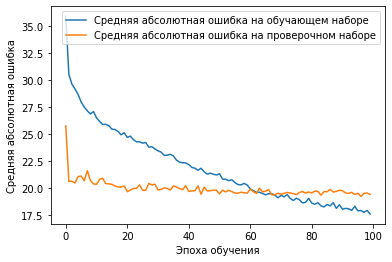

In [22]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [23]:
a = (xTrain01, xTrainRez01)
yy = model.predict(a)

In [25]:
n = 10
for i in range(n):
  print('Реальное значение - ',yTrain[i], " Предсказанное значение - ", round(yy[i][0], 2), " Разница - ", round(abs(yTrain[i]-yy[i][0]), 2))

Реальное значение -  40.0  Предсказанное значение -  38.31  Разница -  1.69
Реальное значение -  40.0  Предсказанное значение -  40.56  Разница -  0.56
Реальное значение -  300.0  Предсказанное значение -  293.95  Разница -  6.05
Реальное значение -  180.0  Предсказанное значение -  164.38  Разница -  15.62
Реальное значение -  40.0  Предсказанное значение -  34.73  Разница -  5.27
Реальное значение -  200.0  Предсказанное значение -  182.33  Разница -  17.67
Реальное значение -  120.0  Предсказанное значение -  113.27  Разница -  6.73
Реальное значение -  50.0  Предсказанное значение -  42.73  Разница -  7.27
Реальное значение -  60.0  Предсказанное значение -  65.79  Разница -  5.79
Реальное значение -  70.0  Предсказанное значение -  69.97  Разница -  0.03
